### Model for fraction of molecules in a given state

We call $x=x_1$ the fraction of stereoisomer 1 (so that $1-x=x_2$). Let $\{X_{k\ell}, w_{k\ell}\}$ be the set of conformations and weights from cluster $k$ of the stereoisomer $\ell$. We can use the model defined in the EMMIVox paper. Specifically, using if $f_i(X, b^f)$ --
[eq. 3 in the paper EMMIVox ](https://www.biorxiv.org/content/10.1101/2023.10.18.562710v1.full.pdf+html) -- is the forward model for the density in voxel $i$ for a given protein conformation $X$, and express:
$$ \langle f_i \rangle = g_i(x) = \\
\langle f_i^{(1)} \rangle + (1-x)
\langle f_i^{(2)} \rangle = \\
x \sum_k w_{k1} f_i(X_{k1}, b^f) +
(1-x) \sum_k w_{k2} f_i(X_{k2}, b^f)$$

#### Model cluster weights (?)
Note that $\sum_k w_{k\ell} f_i(X_{k\ell}, b^f)$ can be also be substituted by the trajectory average $T^{-1} \sum_t f_i(X_{t\ell}, b^f)$ and avoid the clustering.
However, in case one wants to obtain recalibrated weights for the clusters, and therefore refine the docking position based on the density,
one can add the $w_{k\ell}$ parameters in the inference.
This though, makes the posterior not expressed in a close form, so one has to sample it with MCMC.
If $x$ is the only variable, the posterior is very simple.

#### Model for $x$ fraction of epimer
Given this averages $\langle f_i \rangle$, we can express the likelihood for voxel $i$:
$$p(d_i \vert x, \{X_{k\ell}, w_{k\ell}\}, \sigma_i, b_f)
\sim {\cal N}( d_i - \alpha \langle f_i \rangle , \sigma_i)
$$

(We can marginalise the errors $\sigma_i$ as descrbed in EMMIVOX the paper:
$$ p(d_i \vert x, \{X, w\}, b_f) = \int_{\sigma_i^{\rm min}}^\infty
p(d_i \vert x, \{X, w\}, \sigma_i, b_f) p(\sigma_i) d\sigma_i = \\
\frac12 \frac{1}{d_i - \alpha \langle f_i \rangle} {\rm erf} \left ( \frac{d_i - \alpha \langle f_i \rangle}{\sqrt{2} \sigma_i^{\rm min}} \right )
$$

so that the posterior distribution of $x$ is:
$$
p(x\vert {\cal O}) =
p({\cal O}\vert x) p(x) \propto
p(x) \prod_i \frac{1}{d_i - \alpha \langle f_i \rangle} {\rm erf} \left ( \frac{d_i - \alpha \langle f_i \rangle}{\sqrt{2} \sigma_i^{\rm min}} \right )
$$

the log-likelihood then becomes:
$$
{\cal \ell} = \log p(x) - \sum_{i} \log(d_i - \alpha \langle f_i \rangle) + \sum_i \log {\rm erf} (\ldots)
$$

#### Scale parameter $\alpha$

How do we treat this? can we assume that $\alpha \approx 1$?

#### prior for $x$
we can use a weak Beta with the appropriate hyperparameters to center the probability around the value of $x$ in the soak in solution.
$ x \sim {\rm Beta}(2,2) $ centers it on $x\approx 50\%$


# rephrase for my own understanding

1. We have experimental density in each voxel $d_i$ and the corresponding predicted density $f_i$. Assuming that the density in experiment represents a mixture of 2 isomers $d_i=x d_i^{(1)} + (1-x) d_i^{(2)}$, the prediction is also a mixture $f_i(x) = x f_i^{(1)} + (1-x) f_i^{(2)}$. Our ultimate goal is to find the fraction of the isomer bound $x$.
2. The difference between experiment and prediction is attributed to gaussian noise allowing us to use a Bayesian aproach to find $x$. We find $x$ by finding the maximum of the posterior with a weakly-informative prior ($ \mathcal{B}(2,2)$):
$$
p(x|f) = p(f|x)p(x) = \prod_i \frac{1}{d_i - \langle f_i(x) \rangle} {\rm erf} \left ( \frac{d_i - \langle f_i(x) \rangle}{\sqrt{2} \sigma_i^{\rm min}} \right ) \mathcal{B}_{2,2}(x)
$$
3. We can find the maximum of $p(x|f)$ either, if you're smart enough to write down the derivative, analytically or, if you're not so bright, with `scipy.optimize.fmin`

#### ISSUES 
0. Re-writing the above, I have dropped the predicted map scaling parameter $\alpha$. I believe $\alpha$ should be the same for $f_i^{(1)}$ and $f_i^{(2)}$ since we are using the exact same map in both cases. In EMMIVox, $\alpha$ is obtained by finding the value that yields the lowest energy. Below, we are rescaling $f^{(1+2)}$ with the parameters from linear regression of all points of $f^1$ and $f^2$ with $d$
1. EMMIVox does some sort of internal filtering of voxels, which gives us different numbers of voxels, despite having the same input maps and virtually identical starting structures. This means we can not compute the $\langle f_i \rangle$ since the voxels are mismatched. Even when we get an equal number of voxels, we need to make sure that the voxel indices are matched. For now I have fixed this by adding an extra pdb and trj (the second epimer) into the script, so the voxels are based on the set of all voxels between epimers
2. In the paper, $\sigma_i^{\rm min}$ is defined as a voxel-by-voxel variation between two independent reconstructions, or half maps. Here it's unclear how to set these.
3. The maps are interpolated to orthormbic from triclinic using "nearest" interpolation. The points in the interpolated map should match the original 1:1. This needs to be checked and possibly interpolated to a larger number of "voxels"
3. It would be cool to highlight which voxels (hence, protein residues) explain which epimer is bound, if we find any differences
4. We do not use all of the density, but select a neighborhood around the ligand based on a cutoff. This cutoff should be optimized
5. how do we get a confidence interval? We have 5 reps of each epimer, should we use standard deviation from bootstrap? (seaborn does this automatically)
6. Frame clustering/reweighting: We don't need to worry about it since voxel densities are already averaged? (The cryo-EM_validate.py script gives predicted densities simply averaged over all frames) Averaging should be fine since they were sampled under NPT, however, we haven't shown convergence. Or does our model assume we are dealing with discrete states/counts or something?
7. cryo-EM_validate.py has two parameters: cutoff and threshold, which should also be optimized. They control the gaussian cutoff (default is 4 sigma), which probably doesn't matter that much, and map density lower cutoff (threshold, -10000 by default), which doesn't matter since our maps were already normalized to have values above 0.
8. is the integration of $\sigma$ correct? ${\rm erfc} (z) = \int_z^{+\infty}e^{-t^2}dt$ while ${\rm erf} (z) = \int_0^{z}e^{-t^2}dt = 1-{\rm erf}(z)$. This is without normalization to 1. (otherwise we need a prefactor of $\frac{2}{\sqrt{\pi}}$ to account for half interval and area under the gaussian)



#### Marginalization in detail
to marginalize $\sigma$, we need to integrate the joint probability: $p(d|X,b^f) = \int_{\sigma_{\rm min}}^{+\infty}p(d,\sigma|X,b^f)d\sigma$
$$
p(d,\sigma|X,b^f) = p(d|\sigma,X,b^f)p(\sigma)
$$
substituting $p(\sigma)=\frac{1}{\sigma}$ as Jeffreys' prior
$$
p(d|X,b^f) =\int_{\sigma_{\rm min}}^{+\infty} \frac{1}{\sigma \sqrt{2 \pi}} \exp \left[ - \left( \frac{d-\alpha f(X, b^f)}{\sqrt{2 \sigma^2}} \right)^2 \right] \frac{1}{\sigma}  d\sigma =\\
=\frac{1}{\sqrt{2 \pi}}\int_{\sigma_{\rm min}}^{+\infty} \frac{1}{\sigma^2} \exp \left[ - \left( \frac{d-\alpha f(X, b^f)}{\sqrt{2 \sigma^2}} \right)^2 \right] d\sigma
$$




#### Error function
This is the deffinition:
$${\rm erf}\left(\frac{d_i - \alpha f}{\sqrt{2 \sigma^2}}\right) = \int_0^{\frac{d_i - \alpha f}{\sqrt{2 \sigma^2}}}e^{-t^2}dt$$

This is from Wolfram alpha
$$ \frac{1}{\sqrt{2 \pi}} \int_{\sigma_{\rm min}}^{\infty} \frac{1}{\sigma^2} {\rm \exp} \left[ - \left(\frac{d-\alpha f}{\sqrt{2} \sigma} \right)^2  \right] d\sigma
= \frac{1}{2|d - \alpha f|}{\rm erf} \left( \frac{|d- \alpha f|}{\sqrt{2} \sigma_{\rm min}} \right)$$



#### Why aren't we doing linear regression?
1. we get $\alpha$ from doing linear regression with $d \sim a f^{(1+2)} + b$
2. linear regression is, essentially, a least squares model, where we think that the errors are have a normal distribution with mean 0 and try to find $(a, b)$ which minimize the sum of squares of errors
3. we then also maximize the probability that $d_i - f_i^{(1+2)}$ are normally distributed, given a set of variation values in the experimental data $\sigma_i^{\rm min}$. 


#### experimental uncertainty

1. In a simple approach, we set $\sigma$ equal for all the voxels $i$. 
2. We think that $\sigma_i^{\rm min}$ should be on the scale (or equal) of STD of $d_i - f_i^{(1+2)}$
3. Why can't we just integrate $\sigma$ out completely?

#### Why are we using some weird voxel model, where we could be using $f_o - f_c$
1. we can compute the structural factors, given a pdb and compare them to the observed
2. this might be problematic, since the whole protein moves a lot and that would mess up the crystal structure, produce very strange reflections
3. in other words, I think our trajectroy varies too much to be fit into a crystal structure with good resoluteion

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import special
from scipy.stats import beta, linregress

plt.style.use("ggplot")

In [6]:
def get_prior_vals(x, epi_pair):
    """
    Returns an array of probabilities, given an array of xs

    Parameters
    ----------
    x (array) : all values of prior to be examined
    epi_pair (str) : one of the following: "C1/C2","dcGTX2/dcGTX3","GTX2/GTX3"

    Notes
    -----
    The manufacturer fractions (man_frac) come from:
    National Research Council Canada Certificate of Analysis
    CRM-C1&2-c (Lot# 20201208)
    CRM-dcGTX2&3-c (Lot# 20141203)
    CRM-GTX2&3-d (Lot# 20170419)

    """

    # these are in units if uM/l @ 25 deg C
    man_frac = {
        "C1_C2": (93.8, 27.4),
        "dcGTX2_dcGTX3": (100.1, 29.4),
        "GTX2_GTX3": (102.6, 43.5),
    }

    a = man_frac[epi_pair][0] / (man_frac[epi_pair][0] + man_frac[epi_pair][1])
    b = man_frac[epi_pair][1] / (man_frac[epi_pair][0] + man_frac[epi_pair][1])
    c = min(a, b)

    # we want to keep the mean a / (a + b) the same,
    # a and b above 2, to make the distribution concave
    # but as broad as possible. Since a or b can be < 1:
    a /= c / 2
    b /= c / 2
    #   a = 2; b = 2
    print(
        f"prior for {epi_pair}: a = {a}, b = {b}; mean = {a/(a+b)}; mode ="
        f" {(a-1)/(a+b-2)}"
    )
    p = beta.pdf(x, a, b)
    norm = np.sum(beta.pdf(x, a, b))
    return p / norm


def get_delta_d_f_corrected(x, d, f1, f2):
    """
    Returns the difference between experimental data (d)
    and an X-weighted sum (f) of predicted data (f1, f2)
    The resutlting f is then rescaled using a linear regression.

    Parameters
    ----------
    x (float) : fraction of the epimer bound
    f1 (np.array(float)) : prediction of densities in voxels for the first epimer
    f2 (np.array(float)) : prediction of densities in voxels for the second epimer
    d (np.array(float)) : prediction of densities in voxels for the "experimental" PDB

    Returns
    -------

    """
    f = x * f1 + (1 - x) * f2
    scaling_slope, scaling_intercept, r, _, _ = linregress(f, d)
    print(
        f"getting f_corrected for x={x}; "
        f"slope: {scaling_slope:.3}; intercept:"
        f"{scaling_intercept:.3}; R^2: {r}"
    )
    delta_d_f_corrected = scaling_slope * f + scaling_intercept
    return delta_d_f_corrected


def get_delta_d_f_std(x, d, f1_byframe, f2_byframe):
    """this is just the std of voxels over traj"""
    delta_d_f_corrected = []
    for f1, f2 in zip(f1_byframe, f2_byframe):
        f = x * f1 + (1 - x) * f2
        scaling_slope, scaling_intercept, r, _, _ = linregress(f, d)
        scaling_slope * f + scaling_intercept
        delta_d_f_corrected.append(scaling_slope * f + scaling_intercept)
    return np.std(delta_d_f_corrected, axis=0)


def get_neg_log_posterior(delta_d_f, prior_val, sigma_min):
    """
    The objective function in our model. Its minimum corresponds to the maximum posterior of x.
    Assumes the maps x, f1 and f2 have been normalized (alpha)
    It can be optimized with, e.g.,
        fmin(
            neg_log_posterior,
            x0=0.5,
            args=(f1, f2, d, prior, sigma_min),
        )

    Parameters
    ----------
    x (float) : fraction of the epimer bound
    f1 (np.array(float)) : prediction of densities in voxels for the first epimer
    f2 (np.array(float)) : prediction of densities in voxels for the second epimer
    d (np.array(float)) : prediction of densities in voxels for the "experimental" PDB
    prior_val (float) : prior probability value at x
    sigma_min : defined as a voxel-by-voxel variation between
        two independent reconstructions, or half maps;
        in our case, we compute absolute values of diffrerence between 2FoFc for different
        epimers, convert them to electron density and use the voxel values as sigmas

    Returns
    -------
    neg_log_post (float) : negative log posterior. Not normalized

    Notes
    -----
    splitting the erf and its prefactor doesn't work,
    since the erf might be negative
    (which is supposed to be cancelled out by the prefactor)
    """

    log_prior_val = np.log(prior_val)
    log_likelihood = np.sum(
        np.log(
            0.5
            / np.abs(delta_d_f)
            * special.erf(np.abs(delta_d_f) / (np.sqrt(2) * sigma_min))
        )
    )
    neg_log_post = -1 * (log_likelihood)  # + log_prior_val)
    return neg_log_post, -log_prior_val


def get_scaling_from_emmi_out(fname):
    """extracts correlation of mapC with data from cryo-EM_validate.py output"""
    with open(fname) as f:
        scaling_slope, scaling_intercept = [
            (float(l.split()[-4]), float(l.split()[-5]))
            for l in f.readlines()
            if "trjC+trjD" in l
        ][0]
    return scaling_slope, scaling_intercept

<IPython.core.display.Javascript object>

In [7]:
lignames_epi_groupped = [("C1", "C2"), ("GTX2", "GTX3"), ("dcGTX2", "dcGTX3")]
lignames_epi = [v for vv in lignames_epi_groupped for v in vv]


base_folder = "/media/E/STN/round2/emmi_out_2fofc_sigma"

tag = "cut"
# cut means we are using a map prepared with a zoning based on pdb
# not the original interpolated one

<IPython.core.display.Javascript object>

prior for C1_C2: a = 6.846715328467154, b = 2.0; mean = 0.7739273927392739; mode = 0.8539445628997868
prior for GTX2_GTX3: a = 4.7172413793103445, b = 2.0; mean = 0.702258726899384; mode = 0.7880116959064327
prior for dcGTX2_dcGTX3: a = 6.80952380952381, b = 2.0; mean = 0.772972972972973; mode = 0.8531468531468531


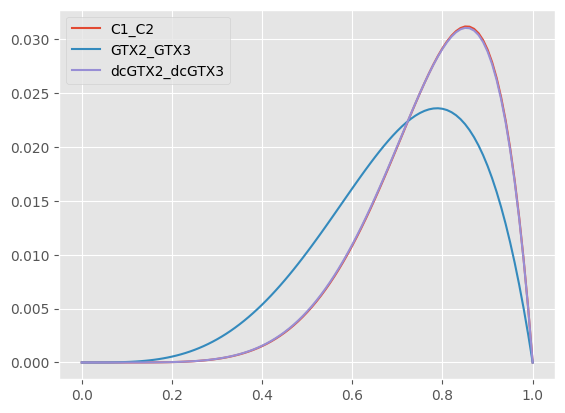

<IPython.core.display.Javascript object>

In [8]:
xs = np.linspace(0, 1, 101)

for ligs in lignames_epi_groupped:
    key = "_".join(ligs)
    prior_vals = get_prior_vals(xs, epi_pair=key)
    plt.plot(xs, prior_vals, label=key)
plt.legend()
plt.show()

### concatenate all repeats

prior for C1_C2: a = 6.846715328467154, b = 2.0; mean = 0.7739273927392739; mode = 0.8539445628997868
getting f_corrected for x=0.1; slope: 1.56; intercept:0.175; R^2: 0.5806738062455644
getting f_corrected for x=0.11; slope: 1.56; intercept:0.174; R^2: 0.5813982650360424
getting f_corrected for x=0.12000000000000001; slope: 1.57; intercept:0.174; R^2: 0.582109568384983
getting f_corrected for x=0.13; slope: 1.57; intercept:0.173; R^2: 0.5828075558574111
getting f_corrected for x=0.14; slope: 1.57; intercept:0.172; R^2: 0.5834920690085368
getting f_corrected for x=0.15000000000000002; slope: 1.58; intercept:0.172; R^2: 0.5841629507993922
getting f_corrected for x=0.16; slope: 1.58; intercept:0.171; R^2: 0.5848200467147378
getting f_corrected for x=0.17; slope: 1.59; intercept:0.171; R^2: 0.5854632046467868
getting f_corrected for x=0.18; slope: 1.59; intercept:0.17; R^2: 0.58609227395033
getting f_corrected for x=0.19; slope: 1.59; intercept:0.169; R^2: 0.5867071065384086
getting f_cor

/tmp/ipykernel_92684/2484940352.py:122: RuntimeWarning: divide by zero encountered in divide
  0.5 / np.abs(delta_d_f) * special.erf(np.abs(delta_d_f) / (np.sqrt(2) * sigma_min))


(0.0, 1.0)

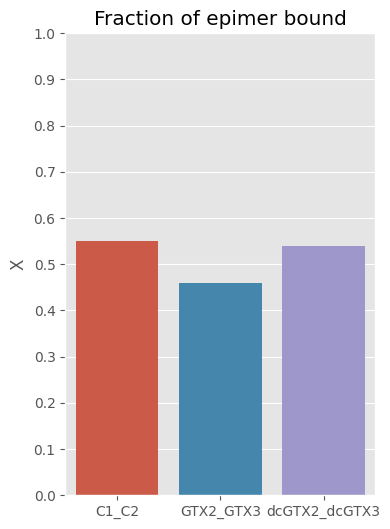

<IPython.core.display.Javascript object>

In [9]:
xs_optimal = {}
ys_all = {}
xs = np.linspace(0.1, 0.9, 81)
nreps = 5

for ligs in lignames_epi_groupped:
    ligs_key = "_".join(ligs)
    xs_optimal.setdefault(ligs_key, [])

    prior_vals = get_prior_vals(xs, epi_pair=ligs_key)

    d = np.tile(
        np.load(
            f"{base_folder}/{ligs_key}_nosol_plumed_flat_voxel_data_{tag}.npy"
        ),
        nreps,
    )
    sigma_mins = np.tile(
        np.abs(
            np.load(
                f"{base_folder}/{ligs_key}_2fofc_difference_nosol_plumed_flat_voxel_data_{tag}.npy"
            )
        ),
        nreps,
    )
    f1 = np.hstack(
        [
            np.load(
                f"{base_folder}/NpSxph_{ligs[0]}_prod_{rep}_emmi_fit2_mapC_{tag}.npy"
            )
            for rep in range(1, 1 + nreps)
        ]
    )
    f2 = np.hstack(
        [
            np.load(
                f"{base_folder}/NpSxph_{ligs[1]}_prod_{rep}_emmi_fit2_mapD_{tag}.npy"
            )
            for rep in range(1, 1 + nreps)
        ]
    )
    f1_byframe = np.hstack(
        [
            np.load(
                f"{base_folder}/NpSxph_{ligs[0]}_prod_{rep}_emmi_fit2_mapC_byframe_{tag}.npy"
            )
            for rep in range(1, 1 + nreps)
        ]
    )
    f2_byframe = np.hstack(
        [
            np.load(
                f"{base_folder}/NpSxph_{ligs[1]}_prod_{rep}_emmi_fit2_mapD_byframe_{tag}.npy"
            )
            for rep in range(1, 1 + nreps)
        ]
    )

    delta_d_fs = [get_delta_d_f_corrected(x, d, f1, f2) for x in xs]
    # sigma_mins = [get_delta_d_f_std(x, d, f1_byframe, f2_byframe) for x in xs]

    ys = []
    likes = []
    for prior_val, delta_d_f in zip(prior_vals, delta_d_fs):
        neg_log_like, neg_log_pri = get_neg_log_posterior(
            delta_d_f, prior_val, sigma_mins
        )
        neg_log_post = neg_log_like + neg_log_pri
        likes.append(neg_log_like)
        ys.append(neg_log_post)

    x_optimal = xs[np.argmin(ys)]
    prior_optimal = prior_vals[np.argmin(ys)]
    xs_optimal[ligs_key].append(x_optimal)
    ys_all[ligs_key] = ys


xs_df = pd.DataFrame(xs_optimal).melt()
fig, ax = plt.subplots(figsize=(4, 6))
sns.barplot(data=xs_df, x="variable", y="value")
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_xlabel("")
ax.set_ylabel("X")
ax.set_title("Fraction of epimer bound")
ax.set_ylim(0, 1)

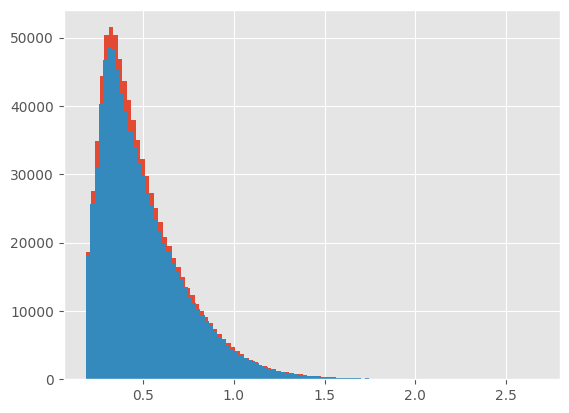

<IPython.core.display.Javascript object>

In [10]:
_ = plt.hist(delta_d_fs[0], bins=100)
_ = plt.hist(delta_d_fs[-1], bins=100)

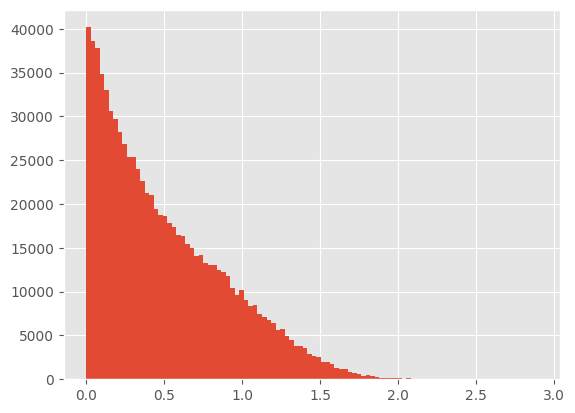

<IPython.core.display.Javascript object>

In [12]:
_ = plt.hist(d, bins=100)

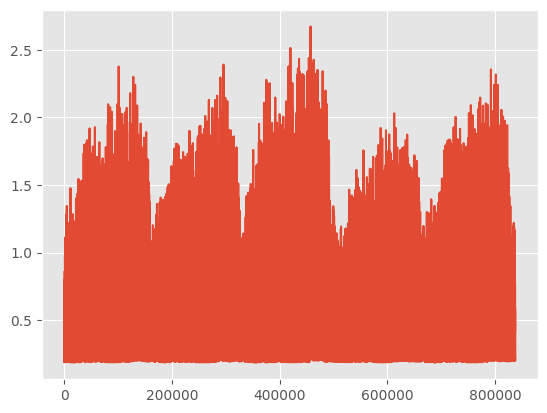

<IPython.core.display.Javascript object>

In [13]:
plt.plot(delta_d_fs[0])

Text(0, 0.5, '$ -\\log(P_{prior})$')

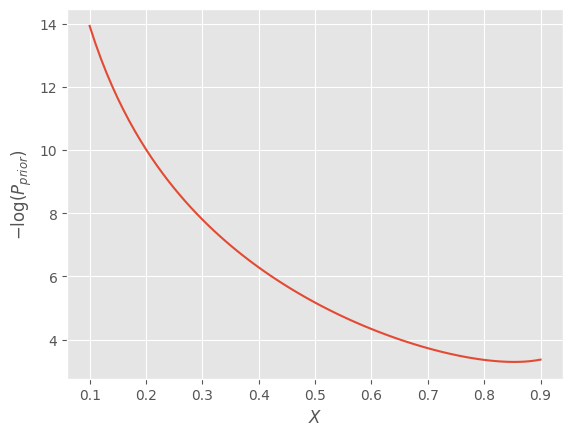

<IPython.core.display.Javascript object>

In [14]:
plt.plot(xs, -np.log(prior_vals))
plt.xlabel("$X$")
plt.ylabel("$ -\log(P_{prior})$")

Text(0, 0.5, '$ -\\log(Likelihood)$')

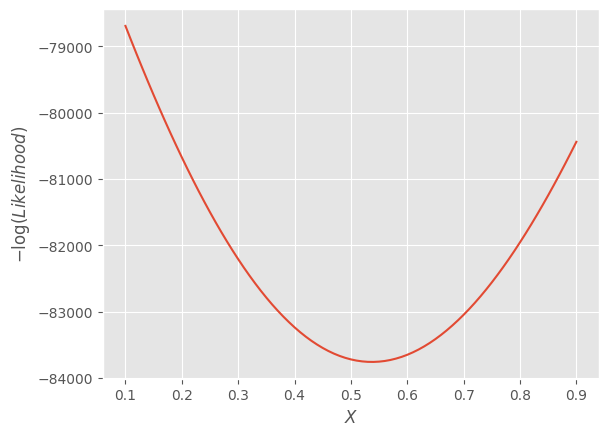

<IPython.core.display.Javascript object>

In [15]:
plt.plot(xs, likes)
plt.xlabel("$X$")
plt.ylabel("$ -\log(Likelihood)$")

(0.0, 1.0)

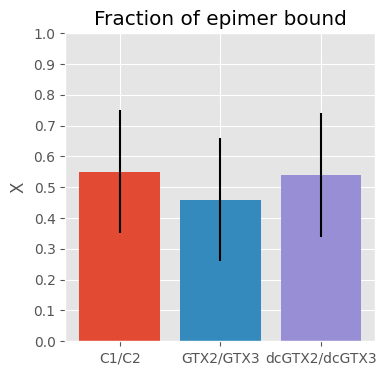

<IPython.core.display.Javascript object>

In [16]:
fig, ax = plt.subplots(figsize=(4, 4))
for xi, ((k, h), y) in enumerate(zip(xs_optimal.items(), ys_all.values())):
    y = np.array(y)
    cdf = np.cumsum(y) / np.sum(y)
    cdf_mean = cdf[np.argmin(y)]
    cdf_hi = cdf_mean + 0.25
    cdf_lo = cdf_mean - 0.25
    x_lo = xs[np.argmin(abs(cdf - cdf_lo))]
    x_hi = xs[np.argmin(abs(cdf - cdf_hi))]

    plt.bar(x=xi, height=h, yerr=[abs(x_lo - h), abs(x_hi - h)])
plt.xticks(
    range(len(lignames_epi_groupped)),
    ["/".join(l) for l in lignames_epi_groupped],
)
plt.ylabel("$X$")
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_xlabel("")
ax.set_ylabel("X")
ax.set_title("Fraction of epimer bound")
ax.set_ylim(0, 1)

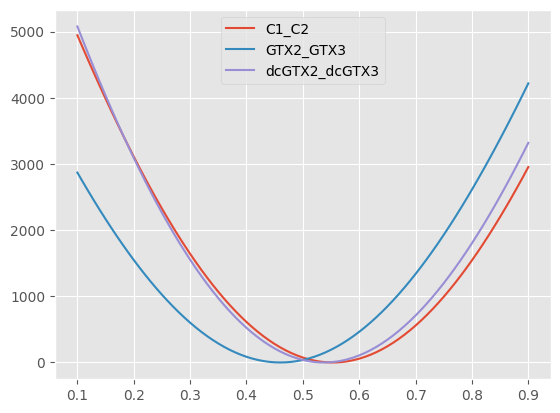

<IPython.core.display.Javascript object>

In [17]:
for k, v in ys_all.items():
    plt.plot(xs, v - min(v), label=k)
plt.legend()

In [18]:
ds = np.load(f"{base_folder}/{ligs_key}_nosol_plumed_flat_voxel_data_{tag}.npy")
sigmas = np.load(
    f"{base_folder}/{ligs_key}_2fofc_difference_nosol_plumed_flat_voxel_data_{tag}.npy"
)

<IPython.core.display.Javascript object>

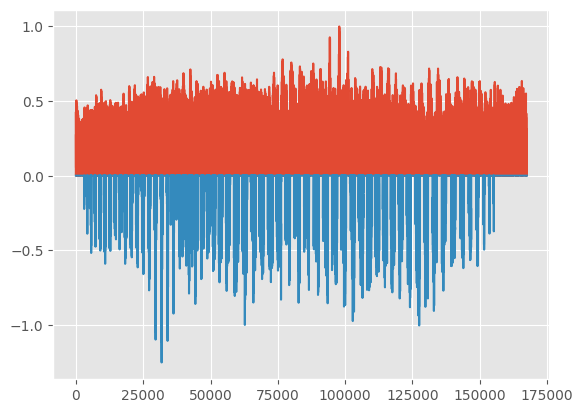

<IPython.core.display.Javascript object>

In [19]:
plt.plot(ds / max(ds))
plt.plot(-np.abs(sigmas / max(sigmas)))

### examine dependence on $\sigma$

In [ ]:
xs_optimal = {}
ys_all = {}
xs = np.linspace(0.01, 0.99, 99)
sigmas = np.hstack([np.linspace(0.01, 0.5, 50), np.linspace(5, 50, 400)])

for ligs in lignames_epi_groupped:
    ligs_key = "_".join(ligs)
    xs_optimal[ligs_key] = []
    prior_vals = get_prior_vals(xs, epi_pair=ligs_key)

    d = np.tile(
        np.load(
            f"{base_folder}/{ligs_key}_nosol_plumed_flat_voxel_data_{tag}.npy"
        ),
        nreps,
    )
    f1 = np.hstack(
        [
            np.load(
                f"{base_folder}/NpSxph_{ligs[0]}_prod_{rep}_emmi_fit2_mapC_{tag}.npy"
            )
            for rep in range(1, 1 + nreps)
        ]
    )
    f2 = np.hstack(
        [
            np.load(
                f"{base_folder}/NpSxph_{ligs[1]}_prod_{rep}_emmi_fit2_mapD_{tag}.npy"
            )
            for rep in range(1, 1 + nreps)
        ]
    )

    ys = []
    delta_d_fs = [get_delta_d_f_corrected(x, d, f1, f2) for x in xs]

    for sigma_min in sigmas:
        print(sigma_min, end="\r")
        ys = [
            sum(
                get_neg_log_posterior(
                    delta_d_f,
                    prior_val,
                    sigma_min,
                )
            )
            for prior_val, delta_d_f in zip(prior_vals, delta_d_fs)
        ]
        ys_all.setdefault(ligs_key, []).append(ys)
        x_optimal = xs[np.argmin(ys)]
        prior_optimal = prior_vals[np.argmin(ys)]
        xs_optimal[ligs_key].append(x_optimal)

cutoff = -1
fig, ax = plt.subplots(figsize=(5, 4))
for ligs in lignames_epi_groupped:
    ligs_key = "_".join(ligs)
    plt.plot(sigmas[:cutoff], xs_optimal[ligs_key][:cutoff], label=ligs_key)
for ligs in lignames_epi_groupped:
    prior_vals = get_prior_vals(xs, epi_pair=ligs_key)

    plt.hlines(
        xs[np.argmax(prior_vals)], min(sigmas), max(sigmas), ls="--", color="k"
    )
plt.xlabel("$\sigma$")
plt.ylabel("X")
plt.legend()
plt.title("Fraction X vs equal $\sigma$ for all voxels in epimer pairs")

prior for C1_C2: a = 6.846715328467154, b = 2.0; mean = 0.7739273927392739; mode = 0.8539445628997868
getting f_corrected for x=0.01; slope: 1.52; intercept:0.182; R^2: 0.5735889986447066
getting f_corrected for x=0.02; slope: 1.53; intercept:0.181; R^2: 0.5744243622761561
getting f_corrected for x=0.03; slope: 1.53; intercept:0.18; R^2: 0.5752480862920314
getting f_corrected for x=0.04; slope: 1.53; intercept:0.179; R^2: 0.576059996885892
getting f_corrected for x=0.05; slope: 1.54; intercept:0.179; R^2: 0.576859921718014
getting f_corrected for x=0.060000000000000005; slope: 1.54; intercept:0.178; R^2: 0.5776476889606682
getting f_corrected for x=0.06999999999999999; slope: 1.55; intercept:0.177; R^2: 0.5784231289694712
getting f_corrected for x=0.08; slope: 1.55; intercept:0.176; R^2: 0.5791860731228888
getting f_corrected for x=0.09; slope: 1.56; intercept:0.176; R^2: 0.5799363542564606
getting f_corrected for x=0.09999999999999999; slope: 1.56; intercept:0.175; R^2: 0.580673806245

In [ ]:
step = 10
start = 0
stop = 50
for y, sigma in zip(ys_all["C1_C2"][start:stop:step], sigmas[start:stop:step]):
    plt.plot(xs, y - min(y), label=sigma.round(2))
plt.legend(title="sigma")
plt.xlabel("X")
plt.ylabel("-log(P(X|$\sigma$,d))")

In [ ]:
step = 10
start = 50
stop = 150
for y, sigma in zip(ys_all["C1_C2"][start:stop:step], sigmas[start:stop:step]):
    plt.plot(xs, y - min(y), label=sigma.round(2))
plt.legend(title="sigma")
plt.xlabel("X")
plt.ylabel("-log(P(X|$\sigma$,d))")

# Parse cryo-EM_validate.py output and plot correlation

('C1', 'C2') 1
('C1', 'C2') 2
('C1', 'C2') 3
('C1', 'C2') 4
('C1', 'C2') 5
('GTX2', 'GTX3') 1
('GTX2', 'GTX3') 2
('GTX2', 'GTX3') 3
('GTX2', 'GTX3') 4
('GTX2', 'GTX3') 5
('dcGTX2', 'dcGTX3') 1
('dcGTX2', 'dcGTX3') 2
('dcGTX2', 'dcGTX3') 3
('dcGTX2', 'dcGTX3') 4
('dcGTX2', 'dcGTX3') 5


(0.5, 0.7)

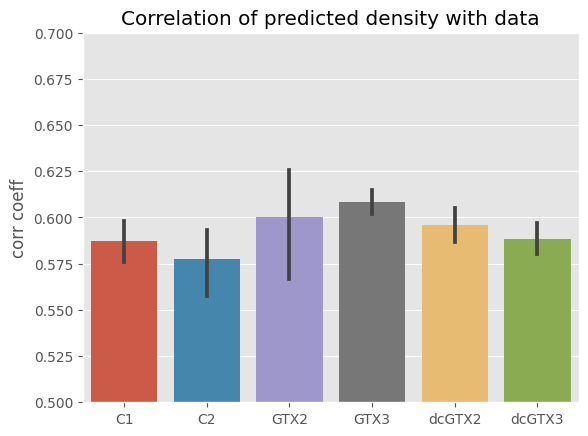

<IPython.core.display.Javascript object>

In [194]:
import pandas as pd
import seaborn as sns


def get_corr_from_emmi_out(fname):
    """extracts correlation of mapC with data from cryo-EM_validate.py output"""
    with open(fname) as f:
        corr = [l.split()[-1] for l in f.readlines() if "CC_mask+ mapC" in l][0]
    return float(corr)


emmi_corr_df = pd.DataFrame()


for ligs in lignames_epi_groupped:
    corrs = {}

    for rep in range(1, 6):
        print(ligs, rep)
        fname1 = f"{base_folder}/{ligs[0]}_{rep}_emmi_validate_{tag}.out"
        fname2 = f"{base_folder}/{ligs[1]}_{rep}_emmi_validate_{tag}.out"
        corrs.setdefault(ligs[0], []).append(get_corr_from_emmi_out(fname1))
        corrs.setdefault(ligs[1], []).append(get_corr_from_emmi_out(fname2))
    emmi_corr_df = pd.concat([emmi_corr_df, pd.DataFrame(corrs).melt()])


sns.barplot(data=emmi_corr_df, x="variable", y="value")
plt.title("Correlation of predicted density with data")
plt.xlabel("")
plt.ylabel("corr coeff")
plt.ylim(0.5, 0.7)

# Calculate structural factors

R-factor: 0.1562


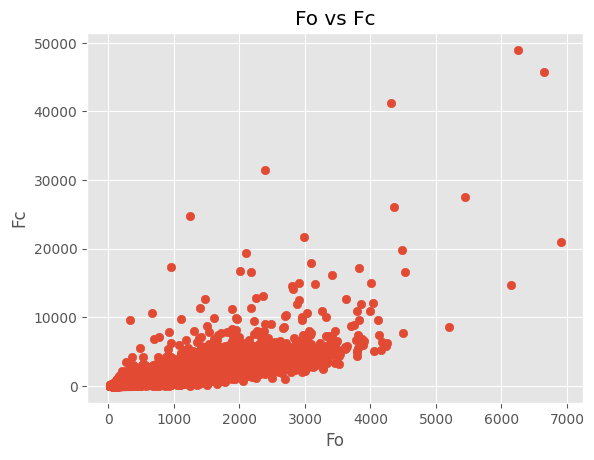

<IPython.core.display.Javascript object>

In [130]:
import matplotlib.pyplot as plt
from cctbx import miller
from cctbx.array_family import flex
from iotbx import pdb, reflection_file_reader

# Step 1: Read the MTZ file and extract Fo
mtz_file = "/media/E/STN/xrd_maps/C1_43.mtz"
reflection_file = reflection_file_reader.any_reflection_file(mtz_file)
miller_arrays = reflection_file.as_miller_arrays()

# Assuming the MTZ file contains columns "F_obs" and "SIGF_obs"
f_obs = None
f_calc = None
for ma in miller_arrays:
    if ma.info().labels == ["F-obs-filtered", "SIGF-obs-filtered"]:
        f_obs = ma
    # if ma.info().labels == ["F-model", "PHIF-model"]:
    #     f_calc = ma

# Step 2: Read the atomic model and calculate Fc
pdb_file = "/media/E/STN/xrd_maps/C1_43.pdb"
pdb_inp = pdb.input(file_name=pdb_file)
xray_structure = pdb_inp.xray_structure_simple()

# Create the miller set for the reflections
f_calc = f_obs.structure_factors_from_scatterers(
    xray_structure=xray_structure
).f_calc()

# Step 3: Compare Fo and Fc
# Extract Fo and Fc as flex arrays
fo = f_obs.data()
fc = flex.abs(f_calc.data())


# Calculate R-factor (example of a comparison metric)
numerator = flex.sum(flex.abs(fo - fc))
denominator = flex.sum(flex.abs(fo + fc))
r_factor = numerator / denominator

print(f"R-factor: {r_factor:.4f}")

# Plot the comparison
plt.scatter(fo, fc)
# plt.scatter(fc, fc)
plt.xlabel("Fo")
plt.ylabel("Fc")
plt.title("Fo vs Fc")
plt.show()

### get sigmas as a difference between Fc's of each epimer

first off, test to see if I understand the data:
1. F_obs - F_model = FoFc
2. 2*F_obs - F_model = 2FoFc
3. 2FoFc - FoFc = F_obs
4. 2FoFc(1) - 2FoFc(2) = FoFc(1) - FoFc(2)


In [497]:
import mrcfile

for ligs in lignames_epi_groupped:
    with mrcfile.open(
        f"{base_folder}/../..//xrd_maps/{ligs[0]}_coot_export_20_ard_lig.mrc",
        "r",
    ) as mrc:
        mx = mrc.header.mx
        my = mrc.header.my
        mz = mrc.header.mz
    unit_cell_grid = (mx, my, mz)
    mtz_file1 = f"{base_folder}/../../xrd_maps/{ligs[0]}.mtz"
    reflection_file1 = reflection_file_reader.any_reflection_file(mtz_file1)
    miller_arrays1 = reflection_file1.as_miller_arrays()

    mtz_file2 = f"{base_folder}/../../xrd_maps/{ligs[1]}.mtz"
    reflection_file2 = reflection_file_reader.any_reflection_file(mtz_file2)
    miller_arrays2 = reflection_file2.as_miller_arrays()

    fo2fc1 = miller_arrays1[5]  # 2FoFc
    fo2fc2 = miller_arrays2[5]
    diff_data1 = fo2fc1.data() - fo2fc2.data()
    diff_miller_array = miller.array(miller_set=fo2fc1, data=diff_data1)

    fofc1 = miller_arrays1[6]  # FoFc
    fofc2 = miller_arrays2[6]
    diff_data2 = fofc1.data() - fofc2.data()
    diff_miller_array2 = miller.array(miller_set=fofc1, data=diff_data2)

    sum_data = fo2fc1.data() + fo2fc2.data()
    sum_miller_array = miller.array(miller_set=fo2fc1, data=sum_data)

    mtz_dataset = diff_miller_array.as_mtz_dataset(column_root_label="d2FOFC")
    mtz_dataset.add_miller_array(diff_miller_array2, column_root_label="dFOFC")
    mtz_dataset.add_miller_array(fo2fc1, column_root_label="2FOFC1")
    mtz_dataset.add_miller_array(fo2fc2, column_root_label="2FOFC2")
    mtz_dataset.add_miller_array(
        sum_miller_array, column_root_label="2FOFC_sum"
    )

    output_file = (
        f"{base_folder}/../../xrd_maps/{'_'.join(ligs)}_fofc_difference_map.mtz"
    )
    mtz_dataset.mtz_object().write(file_name=output_file)

<IPython.core.display.Javascript object>

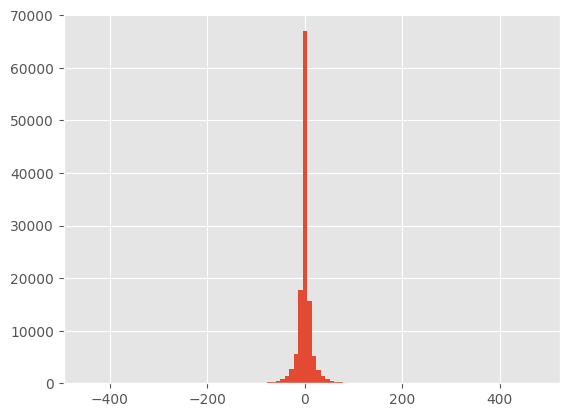

<IPython.core.display.Javascript object>

In [529]:
_ = plt.hist(np.array(diff_miller_array.data()).real, bins=100)

In [297]:
f_obs1 = np.array(miller_arrays1[2].data())
f_mod1 = np.array(miller_arrays1[3].data())
fo2fc1 = np.array(miller_arrays1[5].data())
fofc1 = np.array(miller_arrays1[6].data())

f_obs2 = np.array(miller_arrays2[2].data())
f_mod2 = np.array(miller_arrays2[3].data())
fo2fc2 = np.array(miller_arrays2[5].data())
fofc2 = np.array(miller_arrays2[6].data())

<IPython.core.display.Javascript object>

In [ ]:
f_obs1 - np.abs(f_mod1) == fofc1
2 * f_obs1 - f_mod1 == fo2fc1

# toy model

In [1]:
import matplotlib.pyplot as plt
import numpy as np

x = 0.15
voxelx = np.arange(-100, 100) / 100
f1 = np.exp(-((voxelx - 0.5) ** 2) / (2 * 0.2**2)) * 1 / (
    np.sqrt(0.2)
) + np.exp(-((voxelx - 0.2) ** 2) / (2 * 0.2**2)) * 1 / (np.sqrt(0.2))

f2 = np.exp(-((voxelx + 0.4) ** 2) / (2 * 0.1**2)) * 1 / (
    np.sqrt(0.1)
) + np.exp(-((voxelx + 0.2) ** 2) / (2 * 0.2**2)) * 1 / (np.sqrt(0.2))

alpha = 1
fmean = (
    alpha
    * (x * f1 + (1 - x) * f2)
    * np.exp(np.random.normal(loc=0, scale=0.1, size=len(voxelx)))
)

<IPython.core.display.Javascript object>

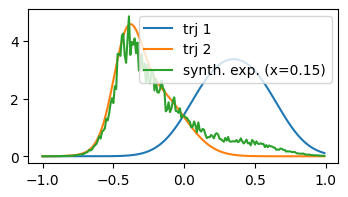

<IPython.core.display.Javascript object>

In [2]:
plt.figure(figsize=(4, 2))

plt.plot(voxelx, f1, label="trj 1")
plt.plot(voxelx, f2, label="trj 2")
plt.plot(voxelx, fmean, label=f"synth. exp. (x={x})")
plt.legend()

In [3]:
from scipy import special
from scipy.stats import beta

## very weak prior
valx = np.arange(0, 100) / 100
priorx = beta.pdf(valx, 2, 2) / np.sum(beta.pdf(valx, 2, 2))

# priorx = (valx*0+1)/np.sum((valx*0+1))
# plt.plot(valx, priorx, label='prior')


def likelihood(x, experiment, dens1, dens2, sigmamin=0.8):
    loc = (
        np.outer(experiment, 1 + 0 * x)
        - np.outer(dens1, x)
        - np.outer(dens2, 1 - x)
    )
    ## fit alpha here!!

    lk = 1 / loc * special.erf(loc / (np.sqrt(2) * sigmamin))
    lk_prod = np.prod(lk, axis=0)
    norm = np.sum(lk_prod)
    return lk_prod / norm

<IPython.core.display.Javascript object>

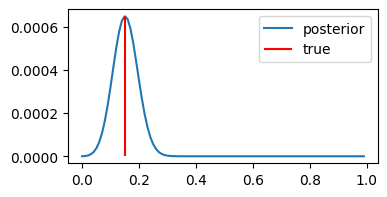

<IPython.core.display.Javascript object>

In [4]:
lk = likelihood(valx, fmean, f1, f2)

# plt.plot(valx, lk, label='likelihood')
posterior = lk * priorx

plt.figure(figsize=(4, 2))

plt.plot(valx, lk * priorx, label="posterior")
plt.vlines(x, 0, np.max(lk * priorx), color="r", label="true")
plt.legend()

In [5]:
mx = np.sum(posterior * valx) / np.sum(posterior)

## there must be a better way to get credible intervals
i25 = np.argmin(np.abs(np.cumsum(posterior / np.sum(posterior)) - 0.25))
i75 = np.argmin(np.abs(np.cumsum(posterior / np.sum(posterior)) - 0.75))

print(f"posterior mean:{mx:.3}, ({valx[i25]:.3}, {valx[i75]:.3})")

posterior mean:0.153, (0.12, 0.18)


<IPython.core.display.Javascript object>